# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test.

Le notebook sera déposé sur la plateforme moodle du cours.

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dataset_path = 'mushrooms'

In [3]:
def Data():
    data_dir = dataset_path
    classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls)) and not cls.startswith('.')]
    
    print("Classes:", classes)

    data_list = []
    for label in classes:
        image_files = os.listdir(os.path.join(data_dir,label))
        data_list.extend([(label,os.path.join(data_dir,label,f)) for f in image_files])

    print("Nombre d'images total:",len(data_list))
    print("Nombre d'images par classes:",[len(os.listdir(os.path.join(data_dir,label))) for label in classes])

    return data_list


In [4]:
data_list = Data()

Classes: ['crimini', 'oyster', 'amanita']
Nombre d'images total: 1643
Nombre d'images par classes: [561, 547, 535]


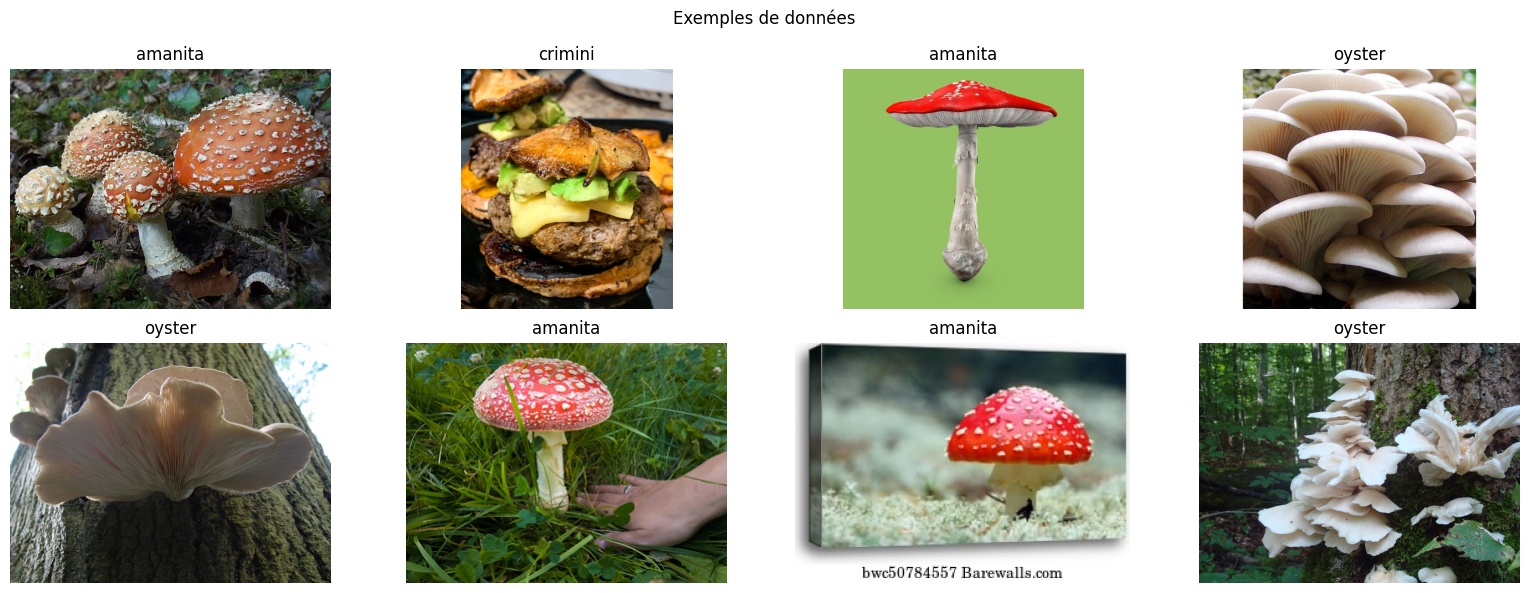

In [5]:
image_samples = np.random.randint(0,high=len(data_list)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(data_list[img_idx][0])
    image = Image.open(data_list[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

# Data

## Hyperparameters

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

## Load Data

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

In [9]:
batch_size = 32
num_epochs = 30
num_workers = 8
learning_rate = 0.001
scheduler_factor = 0.1
scheduler_patience = 2

In [10]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [11]:
"""

TODO: Visualize the training, validation and test samples

# Visualize training, validation and test samples
plt.figure(figsize=(16, 18))

# Training set
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx == 0:  # 只取第一个batch
        for i in range(4):  # 显示4张图片
            ax = plt.subplot(3, 4, i+1)
            img = images[i]
            label = labels[i]
            
            # 将tensor转换为可显示的图像
            img = transforms.ToPILImage()(img)
            ax.imshow(img)
            ax.set_title(f"{train_dataset.dataset.classes[label]}")
            ax.axis('off')
    break

# Validation set
for batch_idx, (images, labels) in enumerate(val_loader):
    if batch_idx == 0:
        for i in range(4):
            ax = plt.subplot(3, 4, i+5)
            img = images[i]
            label = labels[i]
            img = transforms.ToPILImage()(img)
            ax.imshow(img)
            ax.set_title(f"{val_dataset.dataset.classes[label]}")
            ax.axis('off')
    break

# Test set
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx == 0:
        for i in range(4):
            ax = plt.subplot(3, 4, i+9)
            img = images[i]
            label = labels[i]
            img = transforms.ToPILImage()(img)
            ax.imshow(img)
            ax.set_title(f"{test_dataset.dataset.classes[label]}")
            ax.axis('off')
    break

plt.text(0.5, 0.02, 'Training Set', ha='center', transform=plt.gcf().transFigure)
plt.text(0.5, 0.35, 'Validation Set', ha='center', transform=plt.gcf().transFigure)
plt.text(0.5, 0.68, 'Test Set', ha='center', transform=plt.gcf().transFigure)

plt.suptitle(f"Dataset Samples (After Transforms)\nTotal images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
plt.tight_layout()
plt.show()

"""

'\n\nTODO: Visualize the training, validation and test samples\n\n# Visualize training, validation and test samples\nplt.figure(figsize=(16, 18))\n\n# Training set\nfor batch_idx, (images, labels) in enumerate(train_loader):\n    if batch_idx == 0:  # 只取第一个batch\n        for i in range(4):  # 显示4张图片\n            ax = plt.subplot(3, 4, i+1)\n            img = images[i]\n            label = labels[i]\n            \n            # 将tensor转换为可显示的图像\n            img = transforms.ToPILImage()(img)\n            ax.imshow(img)\n            ax.set_title(f"{train_dataset.dataset.classes[label]}")\n            ax.axis(\'off\')\n    break\n\n# Validation set\nfor batch_idx, (images, labels) in enumerate(val_loader):\n    if batch_idx == 0:\n        for i in range(4):\n            ax = plt.subplot(3, 4, i+5)\n            img = images[i]\n            label = labels[i]\n            img = transforms.ToPILImage()(img)\n            ax.imshow(img)\n            ax.set_title(f"{val_dataset.dataset.classes[l

# Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import datetime

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 第一个卷积块
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # 第二个卷积块
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # 第三个卷积块
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Dropout层
        self.dropout = nn.Dropout(0.5)
        # 全连接层
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        # 第一个卷积块
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # 第二个卷积块
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # 第三个卷积块
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # 展平操作
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TrainingMetrics:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.epoch_times = []
        self.best_accuracy = 0
        self.start_time = None

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    metrics = TrainingMetrics()
    metrics.start_time = time.time()
    
    model.train()
    total_steps = len(train_loader)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 统计数据
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 每100步打印详细信息
            if (i + 1) % 100 == 0:
                current_accuracy = 100 * correct / total
                avg_loss = running_loss / 100
                metrics.train_losses.append(avg_loss)
                metrics.train_accuracies.append(current_accuracy)
                
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{i+1}/{total_steps}], '
                      f'Loss: {avg_loss:.4f}, '
                      f'Accuracy: {current_accuracy:.2f}%, '
                      f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
                
                running_loss = 0.0
                correct = 0
                total = 0
        
        # 记录每个epoch的时间
        epoch_time = time.time() - epoch_start
        metrics.epoch_times.append(epoch_time)
        
        # 打印每个epoch的总结
        print(f'\nEpoch {epoch+1} Summary:')
        # print(f'Average Loss: {sum(metrics.train_losses[-len(train_loader)//100:]) / (len(train_loader)//100):.4f}')
        print(f'Average Accuracy: {sum(metrics.train_accuracies[-len(train_loader)//100:]) / (len(train_loader)//100):.2f}%')
        print(f'Epoch Time: {epoch_time:.2f} seconds')
        print('-' * 60)
    
    # 训练结束统计
    total_time = time.time() - metrics.start_time
    print('\nTraining Complete!')
    print(f'Total Training Time: {total_time/60:.2f} minutes')
    print(f'Average Epoch Time: {sum(metrics.epoch_times)/len(metrics.epoch_times):.2f} seconds')
    return metrics

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 3
    class_total = [0] * 3
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # 保存预测结果用于混淆矩阵
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 总体准确率
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 分类准确率
            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
    
    # 打印详细评估结果
    print('\nEvaluation Results:')
    print('=' * 50)
    print(f'总体准确率: {100 * correct / total:.2f}%')
    print('\n类别准确率:')
    for i in range(3):
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'类别 {i}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})')
    
    return {
        'overall_accuracy': 100 * correct / total,
        'class_accuracies': [100 * class_correct[i] / class_total[i] for i in range(3)],
        'predictions': all_predictions,
        'true_labels': all_labels
    }

In [13]:
device = torch.device('mps')
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True)

/Users/neil/miniconda3/envs/PyTorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
metrics = train_model(model, train_loader, criterion, optimizer, device)
eval_results = evaluate_model(model, test_loader, device)

/Users/neil/miniconda3/envs/PyTorch/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/neil/miniconda3/envs/PyTorch/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1 Summary:


ZeroDivisionError: division by zero